In [1]:
import numpy as np
import pickle
import pandas as pd
from functools import reduce

from environments.interface import InterfaceEnvironment

# Necessary Data
with open("..//data//fertility.pkl", "rb") as f:
    fertility_data = pickle.load(f)

with open("..//data//men_wage_path.pkl", "rb") as f:
    men_wage_path_data = pickle.load(f)

with open("..//data//men_hours_empirical", "rb") as f:
    men_hours_data = pickle.load(f)

dropout_prob_df = pd.read_pickle('..//data//dropout_prop.pkl')

def get_dropout_rate(x):
    try:
        v = float(dropout_prob_df['dropout_prop'].loc[dropout_prob_df.index == x])
        if v is not None:
            return v
        else:
            return 0.0
    except:
        return 0.0

# actually 1-dropout_prop 
dropout_prob = np.array(list(map(lambda x: get_dropout_rate(x), range(65))))
educ_start_prob = float(dropout_prob_df['y_true'].loc[dropout_prob_df.index == 18])

men_salary_path = np.array(men_hours_data * men_wage_path_data)

# calculating scales
Q_mean, Q_scale = (60 + 18) * 0.5, (60 - 18) * 0.5
K_mean, K_scale = (0 + 5) * 0.5, (5 - 0) * 0.5
G_mean, G_scale = (0 + 5) * 0.5, (5 - 0) * 0.5
Z_mean, Z_scale = (-200 + 200), (200 - (-200)) * 0.5
B_mean, B_scale = np.ones(4) * 0, np.ones(4) * 1
C_mean, C_scale = np.ones(4) * 8, np.ones(4) * 8
E_prob_mean, E_prob_scale = 0.0, 1.0 
E_mean, E_scale = 0.0, 1.0

beta_K_mean, beta_K_scale = (-5 + 5) * 0.5, (5 - (-5)) * 0.5
beta_L_mean, beta_L_scale = (-5 + 5) * 0.5, (5 - (-5)) * 0.5


def scale_states(Q, G, K, Z, beta_K, beta_L):
    Q = (Q - Q_mean) / Q_scale
    G = (G - G_mean) / G_scale
    K = (K - K_mean) / K_scale
    Z = (Z - Z_mean) / Z_scale

    beta_K = (beta_K - beta_K_mean) / beta_K_scale
    beta_L = (beta_L - beta_L_mean) / beta_L_scale
    return np.array([Q, G, K, Z, beta_K, beta_L])


ACTIONS = [0, 15, 25, 37]


STATES_MU2 = np.concatenate( \
        [np.array([Q_mean, G_mean, K_mean, Z_mean, beta_L_mean, E_prob_mean, E_mean]),B_mean, C_mean]) 

STATES_SIGMA2 = np.concatenate(\
        [np.array([Q_scale, G_scale, K_scale, Z_scale, beta_L_scale, E_prob_scale, E_scale]), B_scale, C_scale])


def translate_action_model2(a):
    return ACTIONS[a]


# values for reward scaler is found by tuning parameters so r_scaled in [-1, 1]
def reward_scaler_model2(r, beta_L):
    return ((r - beta_L * 11.8)  - 121) / 6


class EnvironmentModel2(InterfaceEnvironment):

    """
    Ordering of items
    states: Q, M, K, W
    shocks: epsilon, rho, psi
    """

    DEFAULT_Q = 18
    DEFAULT_G = 2.0
    DEFAULT_K = 0
    DEFAULT_Z = 0.0
    DEFAULT_B = np.zeros(4)
    DEFAULT_C = np.zeros(4)
    DEFAULT_E = 1
    DEFAULT_E_prob = dropout_prob[18] 

    def __init__(
        self, sigma_epsilon, S_min, eta_G, eta_G_sq, alpha, delta, beta_L, zeta
    ):

        # parameters
        self.sigma_epsilon = sigma_epsilon
        self.S_min = S_min
        self.eta_G = eta_G
        self.eta_G_sq = eta_G_sq
        self.alpha = alpha
        self.delta = delta
        self.zeta = zeta
        
        # The parameters that need to be tuned!
        self.beta_L = beta_L

        # states
        self.Q = self.DEFAULT_Q
        self.G = self.DEFAULT_G
        self.K = self.DEFAULT_K
        self.Z = self.DEFAULT_Z
        self.E = self.DEFAULT_E
        self.E_prob = self.DEFAULT_E_prob
        self.B = self.DEFAULT_B
        self.C = self.DEFAULT_C


    def __repr__(self):
        return f"(Q: {self.Q}, G: {self.G}, K: {self.K}, Z: {self.Z})"

    @property
    def states(self):
        array = np.array([self.Q, self.G, self.K, self.Z, self.beta_L, self.E_prob, self.E])
        return np.concatenate([array, self.B, self.C])
        
    def reset(self, states=None, parameters=None):
        """Expect states given as: (Q, G, K, Z, B, C) """
        if states is not None:
            Q, G, K, Z, E_prob, E, B, C = states[0], states[1], states[2], states[3], states[4], states[5]
            self.Q = Q
            self.G = G
            self.K = K
            self.Z = Z
            self.E_prob = E_prob
            self.E = E 
            self.B = B
            self.C = C
        else:
            self.Q = self.DEFAULT_Q
            self.G = self.DEFAULT_G
            self.K = self.DEFAULT_K
            self.Z = self.DEFAULT_Z
            self.E = self.DEFAULT_E * np.random.binomial(1, p=educ_start_prob) # weird implementaion due to randomness
            self.E_prob = self.DEFAULT_E_prob
            self.B = self.DEFAULT_B
            self.C = self.DEFAULT_C

        if parameters is not None:
            for key, val in parameters.items():
                setattr(self, key, val)

        return self.states

    def step(self, action, shocks=None, parameters=None):
        """
        shocks:
            (epsilon, psi) <- that order

        returns:
            (state, reward, done, info)
        """
        if shocks is None:
            shocks = self.draw_shocks()
        epsilon, psi = shocks

        if parameters is not None:
            for key, val in parameters.items():
                setattr(self, key, val)
        # remember action: hours (H)

        ### transition
        self.calc_Q()
        self.calc_E()
        self.calc_E_prob()
        self.calc_Z(epsilon)
        self.calc_K(psi)
        self.calc_B()
        self.calc_C()

        ### model dynamic
        transfer = self.calc_transfer()
        J = self.calc_J()
        L = self.calc_L(action, J)

        # wage/salary process
        log_S_tilde = self.calc_log_S_tilde()
        S = self.calc_S(log_S_tilde)
        W = self.calc_W(S, action)

        # husband income
        M = self.calc_M()

        # household income
        Y = self.calc_Y(W, M, transfer)

        utility = self.calc_U(L, Y)

        self.calc_G(action)

        # this might be changed
        done = self.calc_stops()

        _info = {'Y': Y, 'L': L, 'W': W, 'S': S, 'M': M, 'J': J, 'Q': self.Q, 'transfer': transfer}
        
        if done is True:
            return self.states, utility, True, _info

        return self.states, utility, False, _info
    
    def calc_E(self):
        if self.E < 0.5:
            pass
        else:
            _dropout = np.random.binomial(1, self.E_prob)
            self.E = self.E * _dropout
            
    def calc_E_prob(self):
        self.E_prob = dropout_prob[self.Q]
        

    # model dynamic
    def calc_log_S_tilde(self):
        return self.alpha + self.eta_G * self.G + self.eta_G_sq * self.G ** 2

    def calc_U(self, L, Y):
        u = self.beta_L * L**self.zeta  + Y**self.zeta
        if np.isnan(u):
            raise Exception(f"K: {self.K}, L: {L}, Y: {Y}")
        return u

    def calc_W(self, S, H):
        return S * H

    def calc_M(self):
        # use data (non parametric)
        # return 450000
        try:
            return men_salary_path[self.Q]
        except:
            return men_salary_path[int(self.Q)]

    def calc_Y(self, W, M, transfer):
        return W + M + transfer

    @staticmethod
    def calc_child_work_hours(child_age):
        hours = 0
        if child_age < 3:
            hours = 10
        if 2 < child_age < 16:
            hours = 3.5
        return hours
    
    def calc_J(self):
        child_hours_ = np.array(tuple(map(self.calc_child_work_hours, self.C)))
        child_hours = child_hours_ * self.B
        total_hours = np.sum(child_hours)
        return total_hours
    
    def cap_child_age(C):
        # max age=18, when age > 18, it caps the age at 18
        return C * (C <= 18) * np.ones(4) + (C > 18) * 18
        
    def calc_C(self):
        self.C = self.C + self.B
        return self.C
        
    def calc_B(self):
        B = np.zeros(4)
        B[0:self.K] = 1
        self.B = B
        return self.B
    
    def calc_transfer(self):
        """SU: 6000 * 12 / 52 = 1400"""
        if self.E > 0.5 and self.K < 0.5:
            return 1400
        elif self.E > 0.5 and self.K > 0.5:
            return 1400 * 2
        else:
            return 0
        
    def calc_L(self, hours, J):
        return (7 * 24 - hours - J - self.E*37)

    def calc_stops(self):
        # stops the model (returns done flag)
        if self.Q > 60:
            return True
        return False

    def calc_K(self, psi):
        if self.K < 5:
            self.K = self.K + psi

    def calc_S(self, log_S_tilde):
        _S = np.exp(log_S_tilde) + self.Z
        return max(self.S_min, _S)
        # return 190

    def calc_Q(self):
        self.Q = self.Q + 1

    def calc_G(self, H):
        if self.E < 0.5:
            self.G = self.G * (1 - self.delta) + H / 37

    def calc_Z(self, epsilon):
        self.Z = self.Z + epsilon

    # def shocks
    def draw_shocks(self):
        return (self.draw_epsilon(), self.draw_psi())

    def draw_epsilon(self):
        return np.random.normal(0, self.sigma_epsilon)

    def get_p_psi(self):

        try:
            return fertility_data[self.Q]
        except:
            return fertility_data[int(self.Q)]

    def draw_psi(self):
        p_psi = self.get_p_psi()
        return np.random.binomial(1, p_psi)

    # helpers
    @property
    def observation_space(self):
        return self.states

    @property
    def action_space(self):
        return 4


In [2]:
import matplotlib.pyplot as plt
import seaborn as sbn
import time
f_scale = 0.7
FIGSIZE = (14*f_scale, 8*f_scale)

In [3]:
parameters = {
    'beta_L' : 1,
    'sigma_epsilon' : 0.1, 
    'S_min': 120.0,
    'alpha': 4.609,
    'eta_G': 0.164,
    'eta_G_sq' : 0.015,
    'delta': 0.209,
    'sigma_epsilon': 15.11,
    'zeta': 0.5
}

env = EnvironmentModel2(**parameters)

In [4]:
educ_list = list()
for i in range(500):
    env.reset()
    done = False
    while not done:
        states, utility, done, info = env.step(0)
        educ_list.append({'episode': i, 'age': states[0], 'educ' :states[6], 'educ_prob': states[5]})

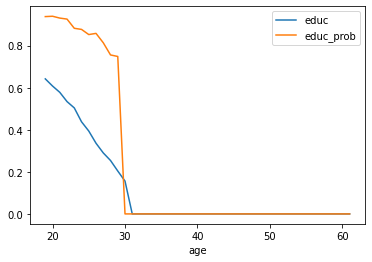

In [5]:
pd.DataFrame(educ_list).groupby('age').mean()[['educ', 'educ_prob']].plot()


In [6]:
env.reset()
sqrt_Ys = list()
Us = list()
N_EPISODES = 3000
actions, action = ACTIONS, -1
beta_L = 0.1
res = list()

for i in range(N_EPISODES):

      
    beta_L = np.random.uniform(0.1, 40)
    env.reset(parameters={'beta_L': beta_L})
    Us_ = list()
    done = False
    scaled_rewards = list()

    while not done:
        action = np.random.randint(0,4)
        states, utility, done, info = env.step(actions[action])
        sqrt_Y = np.sqrt(info['Y'])
        scaled_reward = reward_scaler_model2(utility, beta_L)
        sqrt_Ys.append(sqrt_Y)
        Us.append(utility)
        Us_.append(utility)
        scaled_rewards.append(scaled_reward)
        
    res.append({'beta_L': beta_L, 'U': np.mean(Us_), 'U_min':min(Us_), 'U_max': max(Us_), 'scaled': np.mean(scaled_rewards)})
    

In [7]:
np.mean(sqrt_Ys), np.std(sqrt_Ys)

(112.02570429437417, 17.053066482383624)

In [8]:
np.mean(Us), np.std(Us)

(350.94682761181036, 137.20926784504275)

In [9]:
df_res = pd.DataFrame(res)
np.std(df_res['scaled']), np.mean(df_res['scaled'])

(0.9058336741599523, -1.1700120635744191)

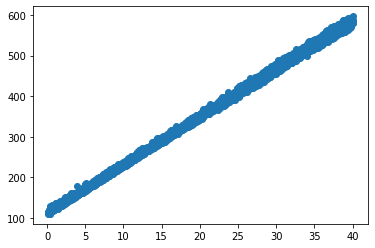

In [10]:
plt.scatter(df_res['beta_L'], df_res['U'])

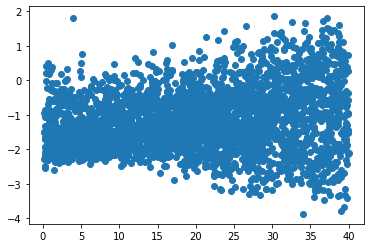

In [11]:
plt.scatter(df_res['beta_L'], df_res['scaled'])

In [12]:
from scipy.stats import linregress

In [13]:
linregress(df_res['beta_L'], df_res['U']).slope

11.904030828237525

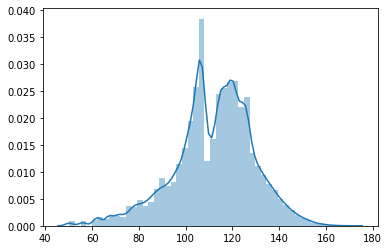

In [14]:


sbn.distplot(sqrt_Ys)

In [15]:
from agents.new_doubledqnagent import DDQNAgent as Agent

Using TensorFlow backend.


In [16]:
def draw_beta_L(beta_L_min=0.1, beta_L_max=12.0):
    return np.random.uniform(beta_L_min, beta_L_max)

def transform_action(dqn_action):
    return np.array(ACTIONS)[dqn_action]

def create_return_array(state, _action, scaled_reward, episode):
    return np.append(state, [_action, scaled_reward, episode])

In [17]:
env = EnvironmentModel2(**parameters)
lr = 0.0005
agent = Agent(gamma=0.99, epsilon=1.0, alpha=lr, input_dims=15,
              n_actions=4, mem_size=1000000, batch_size=64, epsilon_dec=0.9999,
              epsilon_end=0.01, state_scaler_mu = STATES_MU2,
              state_scaler_sigma = STATES_SIGMA2)

In [18]:
N_EPISODES = 3000

Episode: 0 epsilon: 1.0 total score (last 10): nan


/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


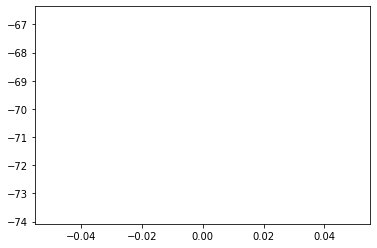

Episode: 10 epsilon: 0.9640599185586783 total score (last 10): -49.04190023639681
Episode: 20 epsilon: 0.9234819910736651 total score (last 10): -62.54569838469578
Episode: 30 epsilon: 0.8846120157265657 total score (last 10): -43.31717996453055
Episode: 40 epsilon: 0.847378103668288 total score (last 10): -13.053470615165018
Episode: 50 epsilon: 0.811711391899535 total score (last 10): -17.492246434528187


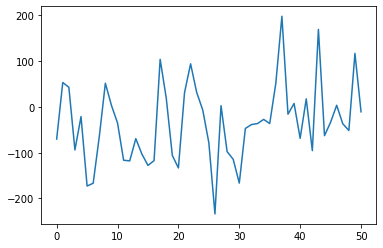

Episode: 60 epsilon: 0.7775459159107581 total score (last 10): 35.40800824194443
Episode: 70 epsilon: 0.7448184876827848 total score (last 10): 50.992823644397134
Episode: 80 epsilon: 0.713468578822478 total score (last 10): 10.301390771177672
Episode: 90 epsilon: 0.6834382086172971 total score (last 10): 16.004969867457223
Episode: 100 epsilon: 0.6546718368017131 total score (last 10): -12.833928004320294


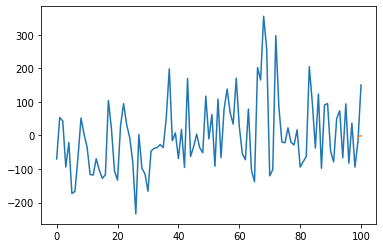

Episode: 110 epsilon: 0.6271162608371637 total score (last 10): -4.451422587502914
Episode: 120 epsilon: 0.600720517515557 total score (last 10): 3.733302813170899
Episode: 130 epsilon: 0.5754357887043543 total score (last 10): 96.20826714581328
Episode: 140 epsilon: 0.5512153110589036 total score (last 10): 87.75020015633945
Episode: 150 epsilon: 0.5280142895350369 total score (last 10): 65.8349045614544


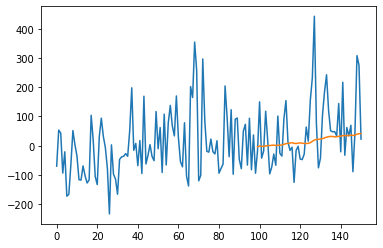

Episode: 160 epsilon: 0.5057898145419926 total score (last 10): 82.53355425284666
Episode: 170 epsilon: 0.484500782582415 total score (last 10): 74.08617931405551
Episode: 180 epsilon: 0.46410782023267466 total score (last 10): 36.36026322079325
Episode: 190 epsilon: 0.4445732113229038 total score (last 10): 56.48130998510175
Episode: 200 epsilon: 0.4258608271820816 total score (last 10): 104.9076785439735


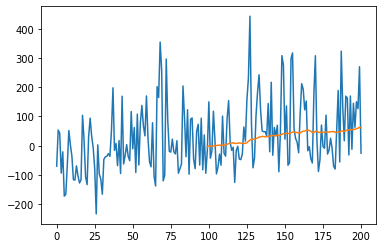

Episode: 210 epsilon: 0.4079360598191387 total score (last 10): 41.994958466639176
Episode: 220 epsilon: 0.3907657579165237 total score (last 10): 145.21101620558218
Episode: 230 epsilon: 0.3743181655178378 total score (last 10): 54.46848380728997
Episode: 240 epsilon: 0.3585628632961515 total score (last 10): 67.75687665477128
Episode: 250 epsilon: 0.3434707122943729 total score (last 10): 80.95450310741609


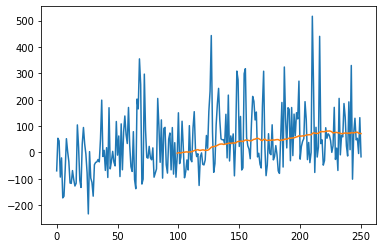

Episode: 260 epsilon: 0.3290138000336249 total score (last 10): 68.8178008114151
Episode: 270 epsilon: 0.3151653888899552 total score (last 10): 177.56493173700682
Episode: 280 epsilon: 0.3018998666439078 total score (last 10): 70.96567522655765
Episode: 290 epsilon: 0.2891926991114924 total score (last 10): 108.59211789952293
Episode: 300 epsilon: 0.2770203847689501 total score (last 10): 100.61121850636596


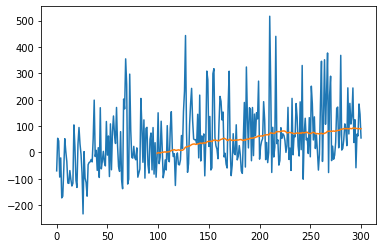

Episode: 310 epsilon: 0.2653604112873939 total score (last 10): 123.93828055397022
Episode: 320 epsilon: 0.2541912138969337 total score (last 10): 148.85337177390414
Episode: 330 epsilon: 0.24349213550328125 total score (last 10): 156.50990324223096
Episode: 340 epsilon: 0.23324338848308065 total score (last 10): 189.10754853336485
Episode: 350 epsilon: 0.22342601808729118 total score (last 10): 100.74764877509394
========> saving new model! New high score: 124.94


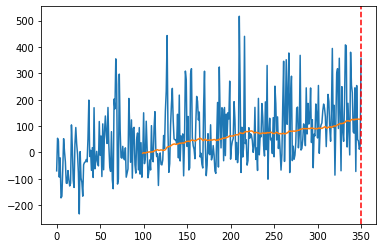

Episode: 360 epsilon: 0.21402186738495152 total score (last 10): 178.88507125188528
Episode: 370 epsilon: 0.20501354368248126 total score (last 10): 138.67351924016998
Episode: 380 epsilon: 0.19638438635641947 total score (last 10): 119.57663620587086
Episode: 390 epsilon: 0.18811843604010126 total score (last 10): 135.65833685225536
Episode: 400 epsilon: 0.180200405107292 total score (last 10): 130.29245218610282
========> saving new model! New high score: 139.82


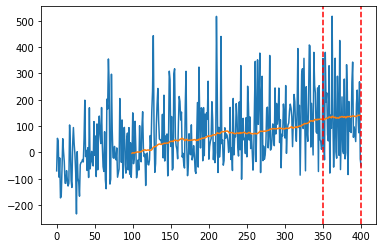

Episode: 410 epsilon: 0.17261564939817997 total score (last 10): 106.98013791359732
Episode: 420 epsilon: 0.16535014113544708 total score (last 10): 49.9327081511779
Episode: 430 epsilon: 0.1583904429803137 total score (last 10): 101.0602813738007
Episode: 440 epsilon: 0.15172368318058757 total score (last 10): 132.70235690153453
Episode: 450 epsilon: 0.14533753176474418 total score (last 10): 149.82612244318983


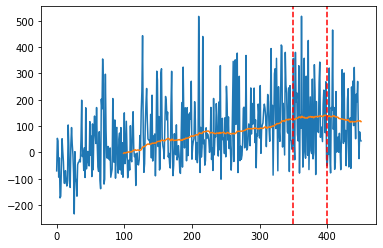

Episode: 460 epsilon: 0.13922017773801795 total score (last 10): 84.24608081393941
Episode: 470 epsilon: 0.13336030723831901 total score (last 10): 167.11757728283777
Episode: 480 epsilon: 0.12774708261159037 total score (last 10): 167.90872669901162
Episode: 490 epsilon: 0.12237012236789019 total score (last 10): 139.0797994119717
Episode: 500 epsilon: 0.11721948198113886 total score (last 10): 206.6144426607242


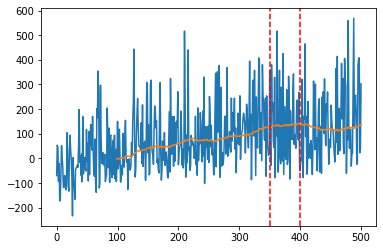

Episode: 510 epsilon: 0.11228563549701923 total score (last 10): 159.23854637427422
Episode: 520 epsilon: 0.107559457915009 total score (last 10): 108.75581939390288
Episode: 530 epsilon: 0.10303220831196792 total score (last 10): 85.2392451832807
Episode: 540 epsilon: 0.09869551367606369 total score (last 10): 106.79013625144724
Episode: 550 epsilon: 0.09454135342113795 total score (last 10): 91.6380117608593
========> saving new model! New high score: 145.24


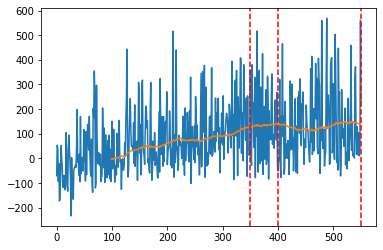

Episode: 560 epsilon: 0.09056204455287445 total score (last 10): 138.52518427884422
Episode: 570 epsilon: 0.08675022745933204 total score (last 10): 136.34325599564852
Episode: 580 epsilon: 0.08309885229956374 total score (last 10): 107.54493076474336
Episode: 590 epsilon: 0.07960116596514924 total score (last 10): 185.17554335574565
Episode: 600 epsilon: 0.07625069959052229 total score (last 10): 128.45666255463294


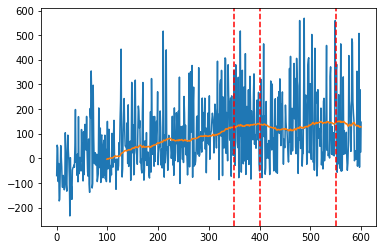

Episode: 610 epsilon: 0.07304125658900062 total score (last 10): 139.37333521758103
Episode: 620 epsilon: 0.06996690119238395 total score (last 10): 186.36996454576212
Episode: 630 epsilon: 0.06702194747293001 total score (last 10): 111.53818224938215
Episode: 640 epsilon: 0.06420094882740288 total score (last 10): 67.13043431210042
Episode: 650 epsilon: 0.0614986879037436 total score (last 10): 185.65689698845569


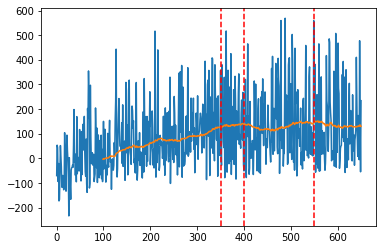

Episode: 660 epsilon: 0.05891016695173428 total score (last 10): 90.52495040209882
Episode: 670 epsilon: 0.05643059857981053 total score (last 10): 218.21150303403206
Episode: 680 epsilon: 0.05405539690092427 total score (last 10): 198.30475922971507
Episode: 690 epsilon: 0.051780169051084124 total score (last 10): 160.64493807868521
Episode: 700 epsilon: 0.049600707064885216 total score (last 10): 91.07244844699805


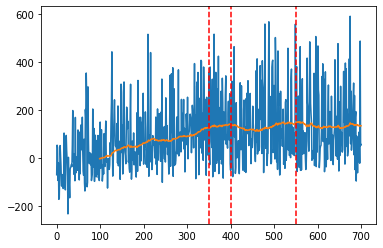

Episode: 710 epsilon: 0.04751298009300428 total score (last 10): 344.5687879870818
Episode: 720 epsilon: 0.045513126947264976 total score (last 10): 228.89456239564652
Episode: 730 epsilon: 0.043597448959486536 total score (last 10): 101.93149725204381
Episode: 740 epsilon: 0.04176240314090865 total score (last 10): 230.30924816292585
Episode: 750 epsilon: 0.0400045956295402 total score (last 10): 123.23344306510756
========> saving new model! New high score: 169.20


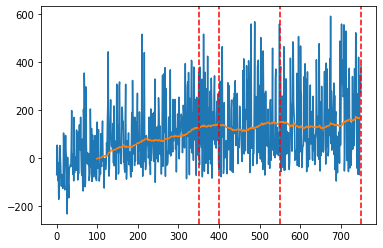

Episode: 760 epsilon: 0.03832077541331378 total score (last 10): 297.7409398794572
Episode: 770 epsilon: 0.036707828317436506 total score (last 10): 214.67775081355143
Episode: 780 epsilon: 0.035162771244817856 total score (last 10): 276.38923803222025
Episode: 790 epsilon: 0.033682746658921174 total score (last 10): 140.3671291876519
Episode: 800 epsilon: 0.032265017298836234 total score (last 10): 224.47279945407234
========> saving new model! New high score: 218.83


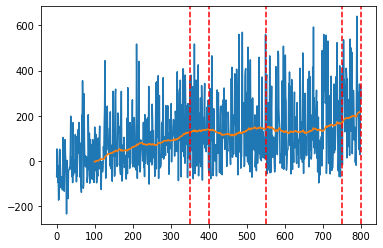

Episode: 810 epsilon: 0.030906961116796926 total score (last 10): 237.50676482720434
Episode: 820 epsilon: 0.02960606642878365 total score (last 10): 168.0926756229026
Episode: 830 epsilon: 0.028359927269238718 total score (last 10): 131.3072255124501
Episode: 840 epsilon: 0.027166238941305806 total score (last 10): 120.67482430972025
Episode: 850 epsilon: 0.026022793754362495 total score (last 10): 167.78344711282733


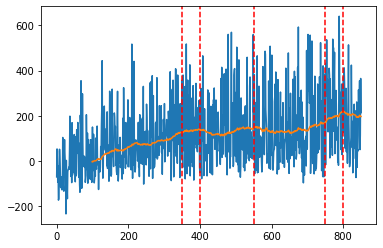

Episode: 860 epsilon: 0.024927476940962916 total score (last 10): 181.65300852535665
Episode: 870 epsilon: 0.02387826274563886 total score (last 10): 173.74393264873572
Episode: 880 epsilon: 0.02287321067832622 total score (last 10): 135.54034681658024
Episode: 890 epsilon: 0.021910461925487082 total score (last 10): 154.09106899558049
Episode: 900 epsilon: 0.020988235912289925 total score (last 10): 188.99154282536296


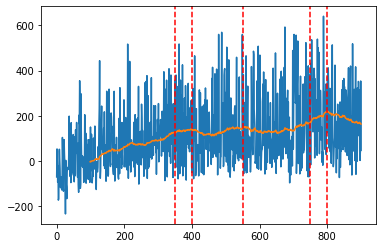

Episode: 910 epsilon: 0.020104827009490085 total score (last 10): 128.63565615386585
Episode: 920 epsilon: 0.019258601378919812 total score (last 10): 246.09158270816886
Episode: 930 epsilon: 0.018447993951753932 total score (last 10): 214.4759355050752
Episode: 940 epsilon: 0.017671505533962 total score (last 10): 127.80576722472749
Episode: 950 epsilon: 0.016927700033594142 total score (last 10): 120.6262325172213


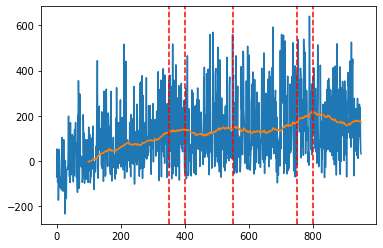

Episode: 960 epsilon: 0.01621520180477221 total score (last 10): 271.79600325033056
Episode: 970 epsilon: 0.015532693103474243 total score (last 10): 173.70948926855124
Episode: 980 epsilon: 0.01487891165040641 total score (last 10): 166.3456431109788
Episode: 990 epsilon: 0.014252648296455585 total score (last 10): 257.4110155413092
Episode: 1000 epsilon: 0.013652744786404457 total score (last 10): 115.40894994546319


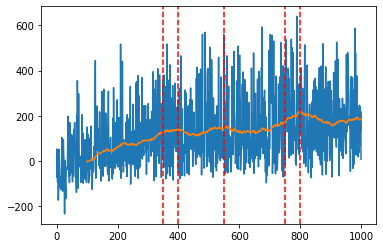

Episode: 1010 epsilon: 0.013078091616773296 total score (last 10): 168.83324375975607
Episode: 1020 epsilon: 0.012527625983826755 total score (last 10): 249.0951724274247
Episode: 1030 epsilon: 0.012000329817950373 total score (last 10): 188.48129834933124
Episode: 1040 epsilon: 0.011495227900761405 total score (last 10): 157.9650873685212
Episode: 1050 epsilon: 0.011011386061471829 total score (last 10): 179.6070484059048


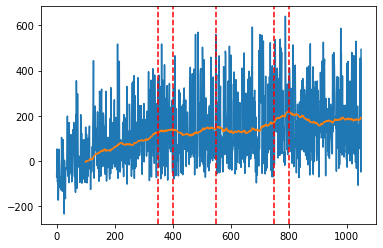

Episode: 1060 epsilon: 0.010547909449167578 total score (last 10): 158.8435337766646
Episode: 1070 epsilon: 0.01010394087780874 total score (last 10): 185.8766027698453
Episode: 1080 epsilon: 0.01 total score (last 10): 134.68052367177225
Episode: 1090 epsilon: 0.01 total score (last 10): 192.43525740921885
Episode: 1100 epsilon: 0.01 total score (last 10): 125.90391067452053


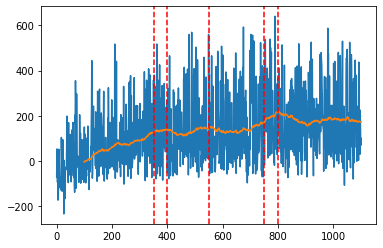

Episode: 1110 epsilon: 0.01 total score (last 10): 122.88554828398476
Episode: 1120 epsilon: 0.01 total score (last 10): 204.554665825821
Episode: 1130 epsilon: 0.01 total score (last 10): 249.92374772417782
Episode: 1140 epsilon: 0.01 total score (last 10): 226.40152639938074
Episode: 1150 epsilon: 0.01 total score (last 10): 175.50383346888714


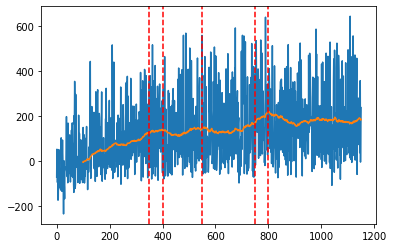

Episode: 1160 epsilon: 0.01 total score (last 10): 243.19639914095944
Episode: 1170 epsilon: 0.01 total score (last 10): 173.34354620281698
Episode: 1180 epsilon: 0.01 total score (last 10): 142.47165521856775
Episode: 1190 epsilon: 0.01 total score (last 10): 189.43921040129192
Episode: 1200 epsilon: 0.01 total score (last 10): 224.67570279415636


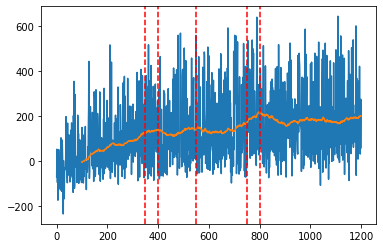

Episode: 1210 epsilon: 0.01 total score (last 10): 189.46218292024005
Episode: 1220 epsilon: 0.01 total score (last 10): 106.95265043890612
Episode: 1230 epsilon: 0.01 total score (last 10): 203.56745232046808
Episode: 1240 epsilon: 0.01 total score (last 10): 159.76301845202343
Episode: 1250 epsilon: 0.01 total score (last 10): 161.7862965485691


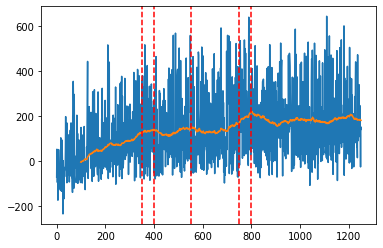

Episode: 1260 epsilon: 0.01 total score (last 10): 261.7880371127652
Episode: 1270 epsilon: 0.01 total score (last 10): 202.68282647687252
Episode: 1280 epsilon: 0.01 total score (last 10): 298.57571749853724
Episode: 1290 epsilon: 0.01 total score (last 10): 185.53366484650675
Episode: 1300 epsilon: 0.01 total score (last 10): 286.1158487512604


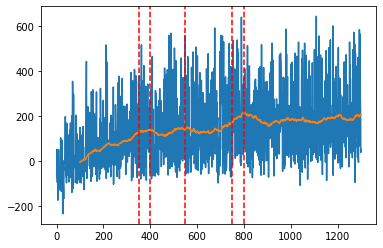

Episode: 1310 epsilon: 0.01 total score (last 10): 222.40357714301018
Episode: 1320 epsilon: 0.01 total score (last 10): 166.41530753057708
Episode: 1330 epsilon: 0.01 total score (last 10): 119.60247590872275
Episode: 1340 epsilon: 0.01 total score (last 10): 259.744278594661
Episode: 1350 epsilon: 0.01 total score (last 10): 269.12605131705124
========> saving new model! New high score: 231.10


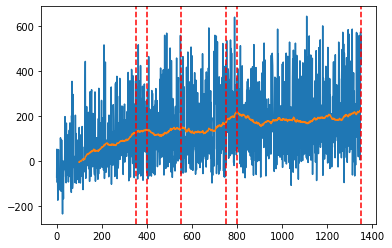

Episode: 1360 epsilon: 0.01 total score (last 10): 203.75838121207525
Episode: 1370 epsilon: 0.01 total score (last 10): 246.55161350594304
Episode: 1380 epsilon: 0.01 total score (last 10): 110.9862300645727
Episode: 1390 epsilon: 0.01 total score (last 10): 160.95689153612327
Episode: 1400 epsilon: 0.01 total score (last 10): 145.0108123858474


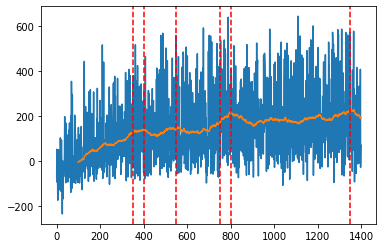

Episode: 1410 epsilon: 0.01 total score (last 10): 231.50306871108555
Episode: 1420 epsilon: 0.01 total score (last 10): 156.32396129681686
Episode: 1430 epsilon: 0.01 total score (last 10): 134.9819896855885
Episode: 1440 epsilon: 0.01 total score (last 10): 234.6094202316412
Episode: 1450 epsilon: 0.01 total score (last 10): 67.37488586103981


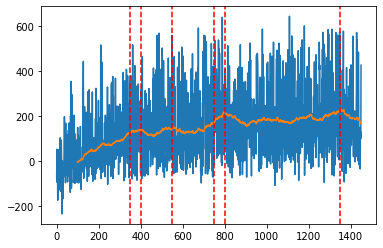

Episode: 1460 epsilon: 0.01 total score (last 10): 273.8979910624426
Episode: 1470 epsilon: 0.01 total score (last 10): 143.06668294357235
Episode: 1480 epsilon: 0.01 total score (last 10): 205.22716091726426
Episode: 1490 epsilon: 0.01 total score (last 10): 149.52961226121883
Episode: 1500 epsilon: 0.01 total score (last 10): 129.11231481252324


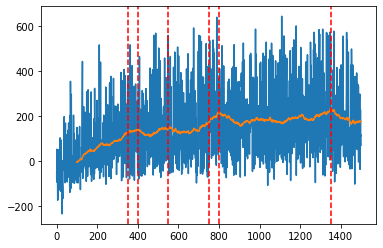

Episode: 1510 epsilon: 0.01 total score (last 10): 140.7214548432561
Episode: 1520 epsilon: 0.01 total score (last 10): 153.02018192511161
Episode: 1530 epsilon: 0.01 total score (last 10): 142.13343075132835
Episode: 1540 epsilon: 0.01 total score (last 10): 125.78422931688695
Episode: 1550 epsilon: 0.01 total score (last 10): 199.88569437835778


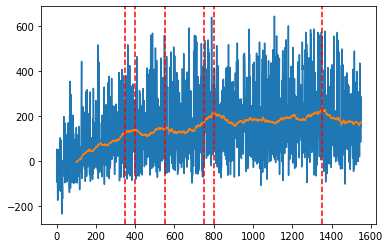

Episode: 1560 epsilon: 0.01 total score (last 10): 172.21145709776562
Episode: 1570 epsilon: 0.01 total score (last 10): 216.04110953256188
Episode: 1580 epsilon: 0.01 total score (last 10): 222.43458164137743
Episode: 1590 epsilon: 0.01 total score (last 10): 216.8970237108424
Episode: 1600 epsilon: 0.01 total score (last 10): 247.60962104347826


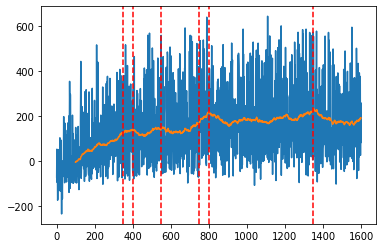

Episode: 1610 epsilon: 0.01 total score (last 10): 147.74149030488152
Episode: 1620 epsilon: 0.01 total score (last 10): 213.5573558618698
Episode: 1630 epsilon: 0.01 total score (last 10): 187.66780137827107
Episode: 1640 epsilon: 0.01 total score (last 10): 215.81080621596482
Episode: 1650 epsilon: 0.01 total score (last 10): 116.45405665371815


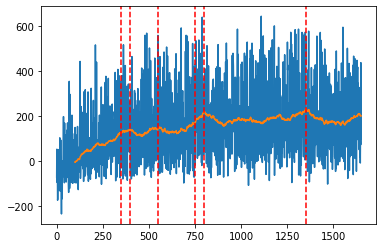

Episode: 1660 epsilon: 0.01 total score (last 10): 147.80108446800202
Episode: 1670 epsilon: 0.01 total score (last 10): 123.71304160044906
Episode: 1680 epsilon: 0.01 total score (last 10): 108.94367111077736
Episode: 1690 epsilon: 0.01 total score (last 10): 146.9631754146753
Episode: 1700 epsilon: 0.01 total score (last 10): 80.04751138463537


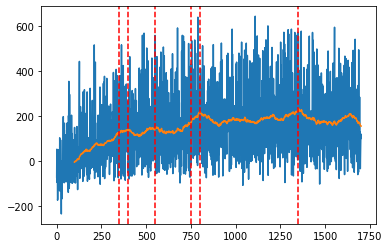

Episode: 1710 epsilon: 0.01 total score (last 10): 166.7587331734516
Episode: 1720 epsilon: 0.01 total score (last 10): 284.1481593184272
Episode: 1730 epsilon: 0.01 total score (last 10): 140.1809600339658
Episode: 1740 epsilon: 0.01 total score (last 10): 181.01563002823514
Episode: 1750 epsilon: 0.01 total score (last 10): 105.47179161940434


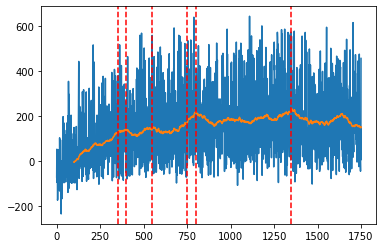

Episode: 1760 epsilon: 0.01 total score (last 10): 277.07770923982787
Episode: 1770 epsilon: 0.01 total score (last 10): 150.56561086104355
Episode: 1780 epsilon: 0.01 total score (last 10): 181.27182054604907
Episode: 1790 epsilon: 0.01 total score (last 10): 142.46911743977375
Episode: 1800 epsilon: 0.01 total score (last 10): 169.2137725103811


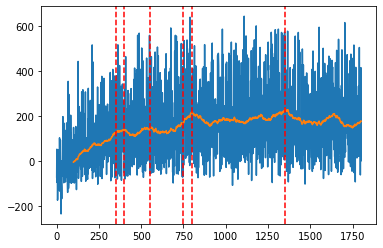

Episode: 1810 epsilon: 0.01 total score (last 10): 213.66559880247385
Episode: 1820 epsilon: 0.01 total score (last 10): 244.7315483089512
Episode: 1830 epsilon: 0.01 total score (last 10): 175.7232159579747
Episode: 1840 epsilon: 0.01 total score (last 10): 183.31786112427042
Episode: 1850 epsilon: 0.01 total score (last 10): 238.53076361994033


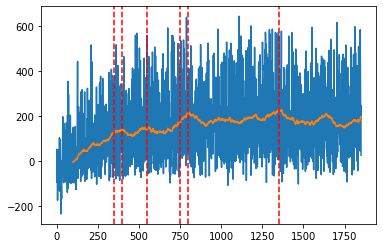

Episode: 1860 epsilon: 0.01 total score (last 10): 161.52981537311254
Episode: 1870 epsilon: 0.01 total score (last 10): 218.19839066744245
Episode: 1880 epsilon: 0.01 total score (last 10): 266.34601182941657
Episode: 1890 epsilon: 0.01 total score (last 10): 126.90959228132218
Episode: 1900 epsilon: 0.01 total score (last 10): 165.6639148254559


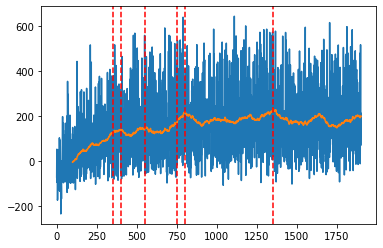

Episode: 1910 epsilon: 0.01 total score (last 10): 153.97808621407296
Episode: 1920 epsilon: 0.01 total score (last 10): 237.55666289659283
Episode: 1930 epsilon: 0.01 total score (last 10): 195.38107717343053
Episode: 1940 epsilon: 0.01 total score (last 10): 187.25039165506664
Episode: 1950 epsilon: 0.01 total score (last 10): 167.32299599183946


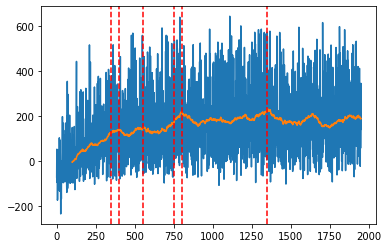

Episode: 1960 epsilon: 0.01 total score (last 10): 177.80830518056797
Episode: 1970 epsilon: 0.01 total score (last 10): 183.3145027839114
Episode: 1980 epsilon: 0.01 total score (last 10): 104.2183206227861
Episode: 1990 epsilon: 0.01 total score (last 10): 171.15448627055764
Episode: 2000 epsilon: 0.01 total score (last 10): 87.83707860000042


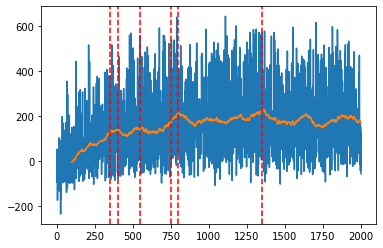

Episode: 2010 epsilon: 0.01 total score (last 10): 92.43005715460235
Episode: 2020 epsilon: 0.01 total score (last 10): 196.1937762082549
Episode: 2030 epsilon: 0.01 total score (last 10): 202.15484139973128
Episode: 2040 epsilon: 0.01 total score (last 10): 172.79914347906208
Episode: 2050 epsilon: 0.01 total score (last 10): 180.8735566644177


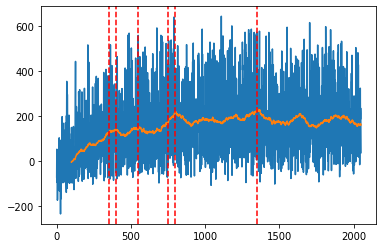

Episode: 2060 epsilon: 0.01 total score (last 10): 135.1110351233787
Episode: 2070 epsilon: 0.01 total score (last 10): 167.6561203252261
Episode: 2080 epsilon: 0.01 total score (last 10): 217.1461825367854
Episode: 2090 epsilon: 0.01 total score (last 10): 152.84634545372649
Episode: 2100 epsilon: 0.01 total score (last 10): 140.92937316008164


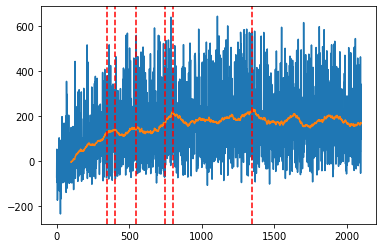

Episode: 2110 epsilon: 0.01 total score (last 10): 114.35497849517196
Episode: 2120 epsilon: 0.01 total score (last 10): 125.1275536365384
Episode: 2130 epsilon: 0.01 total score (last 10): 211.24401038829006
Episode: 2140 epsilon: 0.01 total score (last 10): 221.23853685342377
Episode: 2150 epsilon: 0.01 total score (last 10): 155.90202641349538


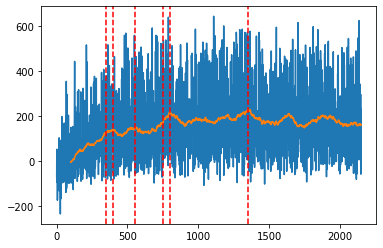

Episode: 2160 epsilon: 0.01 total score (last 10): 294.3300732750667
Episode: 2170 epsilon: 0.01 total score (last 10): 230.55634125001674
Episode: 2180 epsilon: 0.01 total score (last 10): 236.84056163858634
Episode: 2190 epsilon: 0.01 total score (last 10): 171.37980397758898
Episode: 2200 epsilon: 0.01 total score (last 10): 222.91872218909185


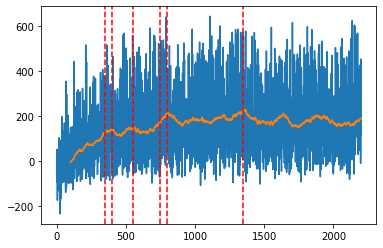

Episode: 2210 epsilon: 0.01 total score (last 10): 253.20702582540838
Episode: 2220 epsilon: 0.01 total score (last 10): 181.83984497740587
Episode: 2230 epsilon: 0.01 total score (last 10): 113.22028094306071
Episode: 2240 epsilon: 0.01 total score (last 10): 298.79271934237545
Episode: 2250 epsilon: 0.01 total score (last 10): 218.1473598075046


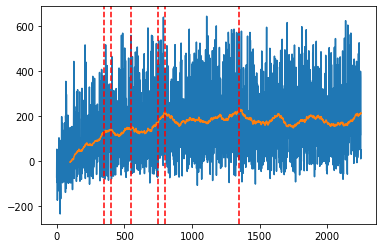

Episode: 2260 epsilon: 0.01 total score (last 10): 192.27123637312604
Episode: 2270 epsilon: 0.01 total score (last 10): 198.3679503826138
Episode: 2280 epsilon: 0.01 total score (last 10): 140.0136281715953
Episode: 2290 epsilon: 0.01 total score (last 10): 142.96727539232413
Episode: 2300 epsilon: 0.01 total score (last 10): 100.45106381864512


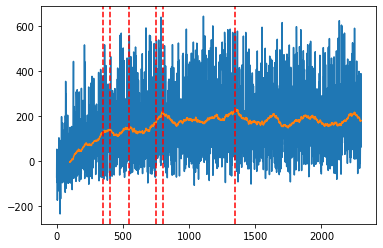

Episode: 2310 epsilon: 0.01 total score (last 10): 135.03074877823215
Episode: 2320 epsilon: 0.01 total score (last 10): 153.6745788223015
Episode: 2330 epsilon: 0.01 total score (last 10): 117.47010518512522
Episode: 2340 epsilon: 0.01 total score (last 10): 205.79933635027615
Episode: 2350 epsilon: 0.01 total score (last 10): 183.57224952085684


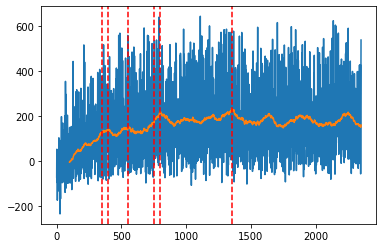

Episode: 2360 epsilon: 0.01 total score (last 10): 206.0275324304477
Episode: 2370 epsilon: 0.01 total score (last 10): 282.3672533319623
Episode: 2380 epsilon: 0.01 total score (last 10): 123.91895754828533
Episode: 2390 epsilon: 0.01 total score (last 10): 279.7034699176118
Episode: 2400 epsilon: 0.01 total score (last 10): 157.92227375419006


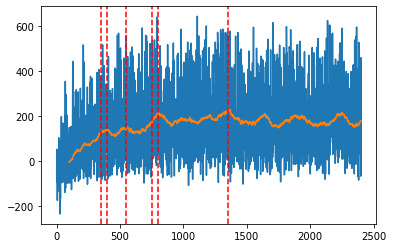

Episode: 2410 epsilon: 0.01 total score (last 10): 214.9388856836444
Episode: 2420 epsilon: 0.01 total score (last 10): 190.54722593821234
Episode: 2430 epsilon: 0.01 total score (last 10): 90.16523366815238
Episode: 2440 epsilon: 0.01 total score (last 10): 154.52556885423206
Episode: 2450 epsilon: 0.01 total score (last 10): 255.98646721812486


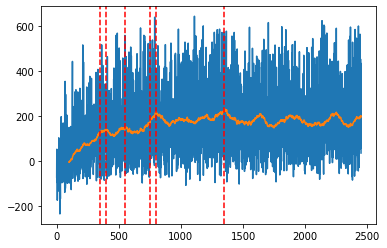

Episode: 2460 epsilon: 0.01 total score (last 10): 129.47694169451603
Episode: 2470 epsilon: 0.01 total score (last 10): 194.15356347437393
Episode: 2480 epsilon: 0.01 total score (last 10): 234.14296178315843
Episode: 2490 epsilon: 0.01 total score (last 10): 274.58751868548757
Episode: 2500 epsilon: 0.01 total score (last 10): 149.34560340649122


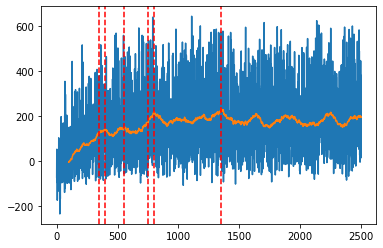

Episode: 2510 epsilon: 0.01 total score (last 10): 158.7113433277925
Episode: 2520 epsilon: 0.01 total score (last 10): 229.4222119870052
Episode: 2530 epsilon: 0.01 total score (last 10): 160.42755787613805
Episode: 2540 epsilon: 0.01 total score (last 10): 158.55701371961175
Episode: 2550 epsilon: 0.01 total score (last 10): 195.4866379641861


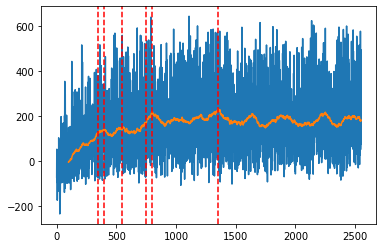

Episode: 2560 epsilon: 0.01 total score (last 10): 190.52687519165553
Episode: 2570 epsilon: 0.01 total score (last 10): 170.14109432641956
Episode: 2580 epsilon: 0.01 total score (last 10): 166.7270099429912
Episode: 2590 epsilon: 0.01 total score (last 10): 169.9932684710397
Episode: 2600 epsilon: 0.01 total score (last 10): 221.50348562497186


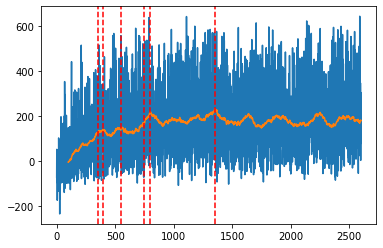

Episode: 2610 epsilon: 0.01 total score (last 10): 215.1622840592386
Episode: 2620 epsilon: 0.01 total score (last 10): 182.31675445959888
Episode: 2630 epsilon: 0.01 total score (last 10): 141.70949937568415
Episode: 2640 epsilon: 0.01 total score (last 10): 129.32297240082605
Episode: 2650 epsilon: 0.01 total score (last 10): 124.6494355722456


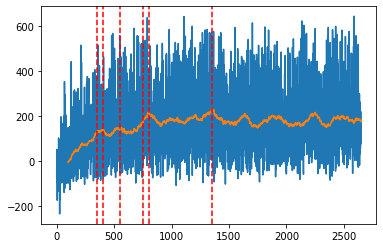

Episode: 2660 epsilon: 0.01 total score (last 10): 169.78521659542184
Episode: 2670 epsilon: 0.01 total score (last 10): 239.95928344418007
Episode: 2680 epsilon: 0.01 total score (last 10): 175.17524920428227
Episode: 2690 epsilon: 0.01 total score (last 10): 229.34359776442955
Episode: 2700 epsilon: 0.01 total score (last 10): 76.7836085858869


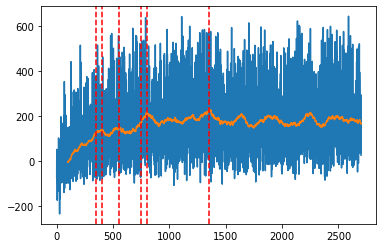

Episode: 2710 epsilon: 0.01 total score (last 10): 178.53198758572182
Episode: 2720 epsilon: 0.01 total score (last 10): 187.97393084598463
Episode: 2730 epsilon: 0.01 total score (last 10): 174.2420848858564
Episode: 2740 epsilon: 0.01 total score (last 10): 165.62765243123232
Episode: 2750 epsilon: 0.01 total score (last 10): 145.79828382039386


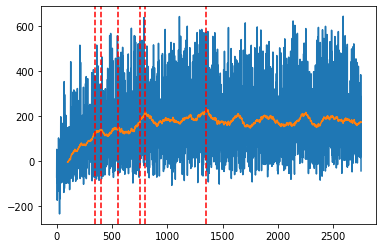

Episode: 2760 epsilon: 0.01 total score (last 10): 245.64989296016432
Episode: 2770 epsilon: 0.01 total score (last 10): 213.3846159710017
Episode: 2780 epsilon: 0.01 total score (last 10): 174.6738994724236
Episode: 2790 epsilon: 0.01 total score (last 10): 107.35683493088582
Episode: 2800 epsilon: 0.01 total score (last 10): 267.4635994329478


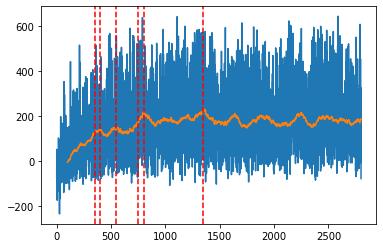

Episode: 2810 epsilon: 0.01 total score (last 10): 134.88232304424307
Episode: 2820 epsilon: 0.01 total score (last 10): 117.77628105420223
Episode: 2830 epsilon: 0.01 total score (last 10): 182.77041148898707
Episode: 2840 epsilon: 0.01 total score (last 10): 156.17765733160712
Episode: 2850 epsilon: 0.01 total score (last 10): 133.53358627366384


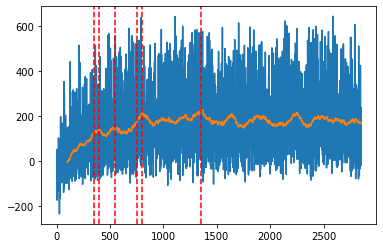

Episode: 2860 epsilon: 0.01 total score (last 10): 168.17671978600438
Episode: 2870 epsilon: 0.01 total score (last 10): 176.30885505223085
Episode: 2880 epsilon: 0.01 total score (last 10): 141.6462271419115
Episode: 2890 epsilon: 0.01 total score (last 10): 195.18502243917717
Episode: 2900 epsilon: 0.01 total score (last 10): 203.36183390019772


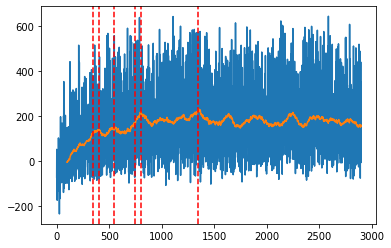

Episode: 2910 epsilon: 0.01 total score (last 10): 203.86340027714402
Episode: 2920 epsilon: 0.01 total score (last 10): 138.87878891537875
Episode: 2930 epsilon: 0.01 total score (last 10): 144.44369383437885
Episode: 2940 epsilon: 0.01 total score (last 10): 201.2624509136972
Episode: 2950 epsilon: 0.01 total score (last 10): 190.9827731569289


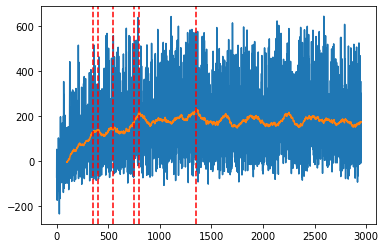

Episode: 2960 epsilon: 0.01 total score (last 10): 188.29207504216558
Episode: 2970 epsilon: 0.01 total score (last 10): 115.23617988485204
Episode: 2980 epsilon: 0.01 total score (last 10): 138.27465956808973
Episode: 2990 epsilon: 0.01 total score (last 10): 191.99073797266826


In [19]:
results = list()
total_score = list()
high_score = 100.0
high_score_episodes = list()

for episode in range(N_EPISODES):
    if episode % 10 == 0:
        print('Episode:', episode, 'epsilon:', agent.epsilon, 'total score (last 10):', np.mean(total_score[-10:-1]))
    beta_L = draw_beta_L(beta_L_max=100.0)
    
    state = env.reset(parameters={'beta_L': beta_L})
    
    done, G = False, 0
    while done is False:
        
        action = agent.choose_action(state)
        _action = transform_action(action)
        new_state, reward, done, info = env.step(_action)
        scaled_reward = reward_scaler_model2(reward, beta_L)
        
        agent.remember(state, action, scaled_reward, new_state, int(done))
        state = new_state
        agent.learn()
        
        G += scaled_reward
        results.append(create_return_array(state, _action, scaled_reward, episode))
    
    total_score.append(G)
    
    if episode % 50 == 0:
        
        plt.plot(total_score)        
        plt.plot(pd.Series(total_score).rolling(100).mean())

        if high_score < np.mean(total_score[-101: -1]):
            high_score = np.mean(total_score[-101: -1])
            print(f'========> saving new model! New high score: {high_score:.2f}')
            agent.save_model(name='models//ddqn_extended')
            high_score_episodes.append(episode)
            
        for high_e in high_score_episodes:
            plt.axvline(high_e, color='red', ls='--')

        plt.show()

        

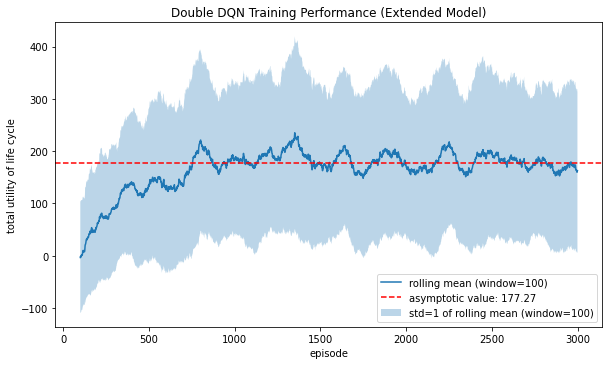

In [20]:
title, fig_scale = 'Double DQN Training Performance (Extended Model)', 0.7

s_ = pd.Series(total_score)
std_ = s_.rolling(100).std()
mean_ = s_.rolling(100).mean()
asymp_val = np.mean(s_[-1000:-1])

f, ax = plt.subplots(1,1, figsize=(14*fig_scale, 8*fig_scale))
ax.fill_between(std_.index, mean_ - std_, mean_ + std_, alpha=0.3, label="std=1 of rolling mean (window=100)")
ax.plot(mean_, label="rolling mean (window=100)")
ax.axhline(asymp_val, label=f"asymptotic value: {asymp_val:.2f}", color='red', ls='--')

ax.set_xlabel('episode')
ax.set_ylabel('total utility of life cycle')

ax.legend(loc='lower right')
ax.set_title(title)

f.savefig('..//figures//ddqn_extended_model_training_performance')


In [21]:
agent.load_model(name='models//ddqn_extended')

In [22]:
agent.epsilon = 0.0

# Estimation

In [23]:
size_multiplier = 0.7
FIGSIZE = (14*size_multiplier, 8*size_multiplier)

In [24]:
with open('..//data//women_hours_empirical', 'rb') as f:
    women_hours = pickle.load(f)

In [25]:
parameters

{'beta_L': 1,
 'sigma_epsilon': 15.11,
 'S_min': 120.0,
 'alpha': 4.609,
 'eta_G': 0.164,
 'eta_G_sq': 0.015,
 'delta': 0.209,
 'zeta': 0.5}

In [26]:
Environment = EnvironmentModel2

In [27]:
#from environments import translate_action_model1 as translate_action

In [28]:
N_SIMS = 800

def simulate_observations(parameters, n_episodes):

    env = Environment(**parameters)

    rewards_history, action_history, states_history = list(), list(), list()
    agent.epsilon=0.0


    for e in range(n_episodes):
        env.reset()
        state = env.states
        for time in range(18, 500):
            action = agent.choose_action(state)
            _action = transform_action(action)
            next_state, reward, done, _ = env.step(_action)
            scaled_reward = (reward - 24 ) / 5

            rewards_history.append([reward, e, time])
            action_history.append([_action, e, time])
            states_history.append(np.append(state, [e, time, _action]))
            
            state = next_state
            if done:
                #print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, np.mean(rewards_history), agent.epsilon))
                break

    df_DQAgent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])
    df_DQAgent_action = pd.DataFrame(action_history, columns=['actions', 'episode', 'Q'])
    
    states_cols = ['Q', 'G', 'K', 'Z', 'beta_L', 'E_prob', 'E', \
                   'b1', 'b2', 'b3', 'b4', 'c1', 'c2', 'c3', 'c4',\
                   'episode', 'time', 'action']
    df_DQAgent_states = pd.DataFrame(states_history, columns=states_cols)
    
    
    return df_DQAgent, df_DQAgent_action, df_DQAgent_states


def get_simulated_mean(df_action):
    sim_avg_actions = df_action.drop('episode',axis=1).loc[df_action['actions'] > 0].groupby('Q').mean()

    sim_vals = np.zeros(shape=90)
    sim_avg_actions
    for ix in range(len(sim_vals)):
        obs = sim_avg_actions.loc[sim_avg_actions.index == ix]
        if len(obs) == 1:

            sim_vals[ix] = float(obs['actions'])

    return sim_vals

def trim_obs(array):
    return array[18:61]

def calc_loss(true_vals, sim_vals):
    return np.mean((true_vals - sim_vals)**2)

def calc_loss_frac_labour(df_action):
    #N_SIMS = N_SIMS
    val = df_action.loc[df_action['actions'] == 0].groupby('Q')['actions'].count() / N_SIMS
    if len(val) == 0:
        val = 1
    return ((np.mean(val) - 0.15) * 37)**2 #times 45 for scaling
    
def objective(x):
    print('\n new iteration')

    np.random.seed(10)
    
    n_episodes = N_SIMS
    
    beta_L = x
    parameters = {
        'beta_L' : x,
        'sigma_epsilon' : 0.1, 
        'S_min': 120.0,
        'alpha': 4.609,
        'eta_G': 0.164,
        'eta_G_sq' : 0.015,
        'delta': 0.209,
        'sigma_epsilon': 15.11,
        'zeta': 0.5
    }
    
    df, df_action, df_states = simulate_observations(parameters, n_episodes)
    sim_vals = get_simulated_mean(df_action)
    true_vals, sim_vals = trim_obs(women_hours), trim_obs(sim_vals)
    mse_hours = calc_loss(true_vals, sim_vals)
    mse_fraction = calc_loss_frac_labour(df_action)
    mse = mse_hours + mse_fraction
    print(f'beta L: {beta_L:.1f}, mse_hours: {mse_hours:.1f}, mse_fraction: {mse_fraction:.1f}, mse, {mse:.1f}')
    
    return mse 

In [29]:
beta_Ls, mses = np.linspace(0.0, 60.0), list()

for beta_L in beta_Ls:
    mse = objective(beta_L)
    mses.append(mse)


 new iteration
beta L: 0.0, mse_hours: 50.6, mse_fraction: 28.8, mse, 79.4

 new iteration
beta L: 1.2, mse_hours: 51.9, mse_fraction: 28.5, mse, 80.4

 new iteration
beta L: 2.4, mse_hours: 53.0, mse_fraction: 28.1, mse, 81.1

 new iteration
beta L: 3.7, mse_hours: 54.1, mse_fraction: 27.8, mse, 81.9

 new iteration
beta L: 4.9, mse_hours: 56.1, mse_fraction: 27.6, mse, 83.6

 new iteration
beta L: 6.1, mse_hours: 57.7, mse_fraction: 26.2, mse, 83.9

 new iteration
beta L: 7.3, mse_hours: 60.5, mse_fraction: 25.8, mse, 86.3

 new iteration
beta L: 8.6, mse_hours: 61.6, mse_fraction: 24.9, mse, 86.5

 new iteration
beta L: 9.8, mse_hours: 65.4, mse_fraction: 24.7, mse, 90.1

 new iteration
beta L: 11.0, mse_hours: 65.4, mse_fraction: 23.0, mse, 88.3

 new iteration
beta L: 12.2, mse_hours: 64.4, mse_fraction: 21.3, mse, 85.7

 new iteration
beta L: 13.5, mse_hours: 63.1, mse_fraction: 22.2, mse, 85.2

 new iteration
beta L: 14.7, mse_hours: 59.8, mse_fraction: 20.9, mse, 80.6

 new it

In [30]:
agent.choose_action(state)

3

In [31]:
# ENDOGENT FIND MIN BETA_L

beta_L_ix = np.argmin(np.log(mses))
beta_L = beta_Ls[beta_L_ix]
print('beta_L:', beta_L, 'beta_L_ix:' ,beta_L_ix)

beta_L: 24.48979591836735 beta_L_ix: 20


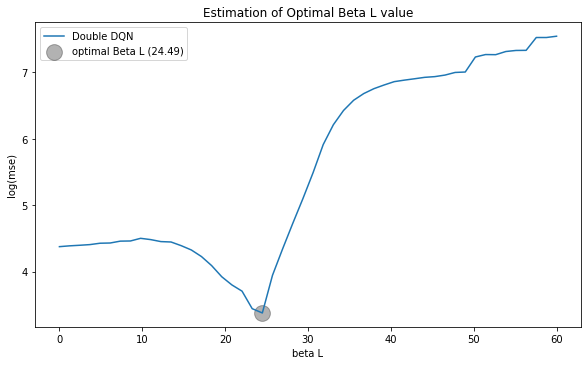

In [32]:
f, ax = plt.subplots(1,1, figsize = (14*fig_scale, 8*fig_scale))
ax.plot(beta_Ls, np.log(mses), label='Double DQN')
ax.set_title('Estimation of Optimal Beta L value')
ax.set_ylabel('log(mse)')
ax.set_xlabel('beta L')
ax.scatter(beta_L, np.log(np.min(mses)), s=250, alpha=0.3, color='black', label=f'optimal Beta L ({beta_L:.2f})')
ax.legend()

f.savefig('..//figures//ddqn_extended_model_estimation_beta_L')

In [33]:
#beta_Ls_2, mses_2 = np.linspace(10.0, 40.0), list()

#for beta_L in beta_Ls_2:
#    mse = objective(beta_L)
#    mses_2.append(mse)

In [34]:
#plt.plot(beta_Ls_2, np.log(mses_2))

In [35]:
print('beta_L:', beta_L, 'beta_L_ix:' ,beta_L_ix)
alt_beta_L = 23.26

beta_L: 24.48979591836735 beta_L_ix: 20


In [36]:
# beta_L: 25.7 #(virker godt)
# beta_L = 22.0

In [81]:
parameters = {
    'beta_L' : beta_L,
    'sigma_epsilon' : 0.1, 
    'S_min': 120.0,
    'alpha': 4.609,
    'eta_G': 0.164,
    'eta_G_sq' : 0.015,
    'delta': 0.209,
    'sigma_epsilon': 15.11,
    'zeta': 0.5
}

env = EnvironmentModel2(**parameters)

In [82]:
N_EPISODES = 10000

results = list()
infos = list()
total_score = list()

tic = time.time()
for episode in range(N_EPISODES):

    if episode % 50 == 0:
        print('Episode:', episode, 'epsilon:', agent.epsilon, f'total score (last 10): {np.mean(total_score[-10:-1]):.1f}')
        
        toc = time.time()
        time_for_50 = toc - tic
        remaining_episodes = N_EPISODES - episode
        
        print(f'time for 50 episodes:{time_for_50:.1f} seconds. Remaining {( remaining_episodes / 50 ) * time_for_50 / 60:.1f} minutes')
        tic = time.time()
        
    state = env.reset()
    
    done, G = False, 0
    while done is False:
        
        action = agent.choose_action(state)
        _action = transform_action(action)
        new_state, reward, done, info = env.step(_action)
        scaled_reward = reward_scaler_model2(reward, beta_L)
        
        state = new_state
        
        G += scaled_reward
        results.append(create_return_array(state, _action, scaled_reward, episode))
        infos.append(info)
        
    total_score.append(G)
    

/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode: 0 epsilon: 0.0 total score (last 10): nan
time for 50 episodes:0.0 seconds. Remaining 0.0 minutes
Episode: 50 epsilon: 0.0 total score (last 10): 3.6
time for 50 episodes:2.5 seconds. Remaining 8.3 minutes
Episode: 100 epsilon: 0.0 total score (last 10): 19.5
time for 50 episodes:2.4 seconds. Remaining 7.8 minutes
Episode: 150 epsilon: 0.0 total score (last 10): 24.5
time for 50 episodes:2.1 seconds. Remaining 6.9 minutes
Episode: 200 epsilon: 0.0 total score (last 10): 32.9
time for 50 episodes:2.0 seconds. Remaining 6.5 minutes
Episode: 250 epsilon: 0.0 total score (last 10): 20.5
time for 50 episodes:4.4 seconds. Remaining 14.2 minutes
Episode: 300 epsilon: 0.0 total score (last 10): -8.1
time for 50 episodes:2.0 seconds. Remaining 6.6 minutes
Episode: 350 epsilon: 0.0 total score (last 10): 21.5
time for 50 episodes:2.5 seconds. Remaining 8.1 minutes
Episode: 400 epsilon: 0.0 total score (last 10): 14.4
time for 50 episodes:2.0 seconds. Remaining 6.3 minutes
Episode: 450 e

Episode: 3750 epsilon: 0.0 total score (last 10): 24.4
time for 50 episodes:1.5 seconds. Remaining 3.2 minutes
Episode: 3800 epsilon: 0.0 total score (last 10): 15.3
time for 50 episodes:1.6 seconds. Remaining 3.2 minutes
Episode: 3850 epsilon: 0.0 total score (last 10): 23.2
time for 50 episodes:1.5 seconds. Remaining 3.2 minutes
Episode: 3900 epsilon: 0.0 total score (last 10): 10.9
time for 50 episodes:1.7 seconds. Remaining 3.6 minutes
Episode: 3950 epsilon: 0.0 total score (last 10): 29.9
time for 50 episodes:1.8 seconds. Remaining 3.7 minutes
Episode: 4000 epsilon: 0.0 total score (last 10): 32.0
time for 50 episodes:1.6 seconds. Remaining 3.1 minutes
Episode: 4050 epsilon: 0.0 total score (last 10): 21.1
time for 50 episodes:1.5 seconds. Remaining 3.0 minutes
Episode: 4100 epsilon: 0.0 total score (last 10): 24.1
time for 50 episodes:1.6 seconds. Remaining 3.1 minutes
Episode: 4150 epsilon: 0.0 total score (last 10): -5.3
time for 50 episodes:1.5 seconds. Remaining 2.9 minutes
E

Episode: 7450 epsilon: 0.0 total score (last 10): 34.6
time for 50 episodes:1.5 seconds. Remaining 1.3 minutes
Episode: 7500 epsilon: 0.0 total score (last 10): 5.5
time for 50 episodes:1.5 seconds. Remaining 1.2 minutes
Episode: 7550 epsilon: 0.0 total score (last 10): 21.0
time for 50 episodes:1.5 seconds. Remaining 1.2 minutes
Episode: 7600 epsilon: 0.0 total score (last 10): -11.6
time for 50 episodes:1.5 seconds. Remaining 1.2 minutes
Episode: 7650 epsilon: 0.0 total score (last 10): -10.0
time for 50 episodes:1.5 seconds. Remaining 1.2 minutes
Episode: 7700 epsilon: 0.0 total score (last 10): 2.9
time for 50 episodes:1.5 seconds. Remaining 1.1 minutes
Episode: 7750 epsilon: 0.0 total score (last 10): 37.6
time for 50 episodes:1.5 seconds. Remaining 1.1 minutes
Episode: 7800 epsilon: 0.0 total score (last 10): 16.8
time for 50 episodes:1.5 seconds. Remaining 1.1 minutes
Episode: 7850 epsilon: 0.0 total score (last 10): 40.9
time for 50 episodes:1.5 seconds. Remaining 1.1 minutes
E

In [83]:
states_cols = ['Q', 'G', 'K', 'Z', 'beta_L', 'E_prob', 'E', \
               'b1', 'b2', 'b3', 'b4', 'c1', 'c2', 'c3', 'c4',\
               'action', 'scaled_reward', 'episode']

In [84]:
df_results = pd.DataFrame(results, columns=states_cols)

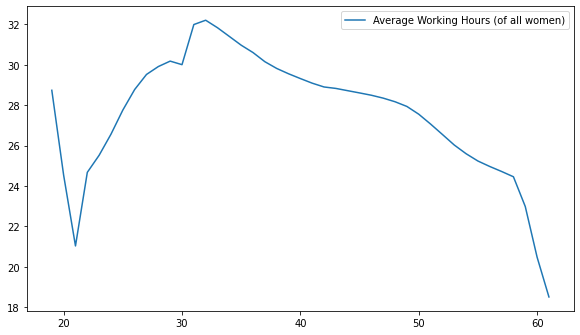

In [85]:
f, ax = plt.subplots(1,1,figsize=FIGSIZE)
plt.plot(df_results.groupby('Q')['action'].mean(), label = 'Average Working Hours (of all women)')
ax.legend()

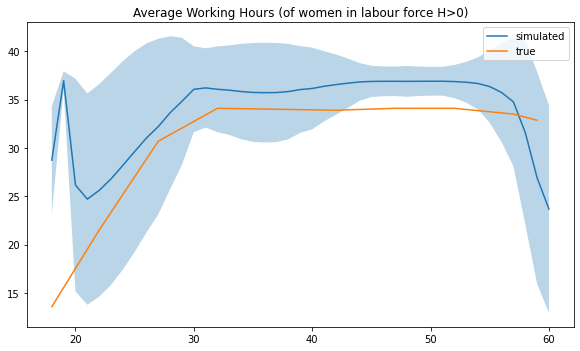

In [86]:
with open("..//data//women_hours_empirical", "rb") as f:
    women_hours_data = pickle.load(f)

f, ax = plt.subplots(1,1, figsize=FIGSIZE)
_x = range(18,60)
_xx = range(18, 61)
_mean = df_results.loc[df_results['action'] > 0].groupby('Q')['action'].mean()
_std = df_results.loc[df_results['action'] > 0].groupby('Q')['action'].std()
ax.plot(_xx, _mean, label='simulated')
ax.fill_between(_xx, _mean -_std, _mean + _std, alpha=0.3)
ax.plot(_x,women_hours_data[18:60], label = 'true')
ax.set_title("Average Working Hours (of women in labour force H>0)")
ax.legend()

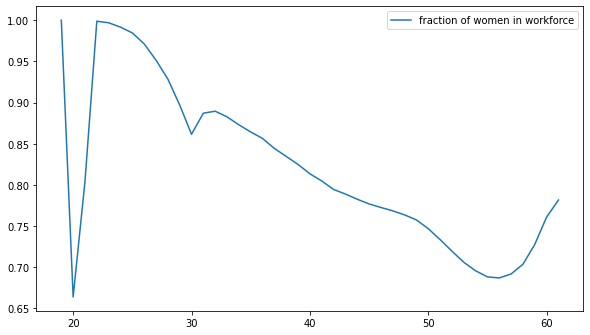

In [87]:

f, ax = plt.subplots(1,1, figsize=FIGSIZE)
ax.plot(df_results.loc[df_results['action'] > 0].groupby('Q')['action'].count() / max(df_results['episode']) ,label='fraction of women in workforce')
ax.legend()


In [88]:
df_results.loc[df_results['action'] == 0]['action'].count() / df_results['action'].count()

0.1797

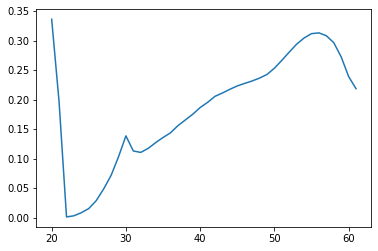

In [89]:
plt.plot(df_results.loc[df_results['action'] < 1].groupby('Q')['action'].count() / 10000)

(array([ 77271.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,  50179.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,   6922.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 295628.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5,
        21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5,
        32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5,
        43.5, 44.5, 45.5, 46.5]),
 <a list of 47 Patch objects>)

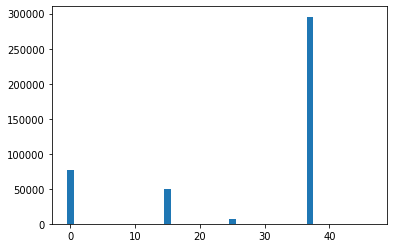

In [90]:
plt.hist(df_results['action'], bins = [- 0.5 + x for x in range(48)])

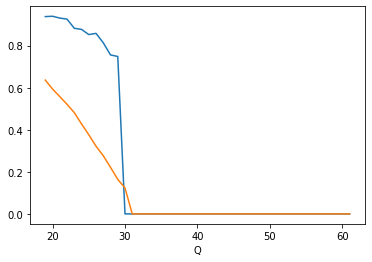

In [91]:
df_results.groupby('Q')['E_prob'].mean().plot()
df_results.groupby('Q')['E'].mean().plot()

In [92]:
df_results['K_plus'] = df_results['K'].shift(-1)
df_results['K_plus_20'] = df_results['K'].shift(-20)

In [93]:

kids1 = set(df_results.loc[(df_results['K'] == 0) & \
            (df_results['K_plus'] == 1) & (df_results['Q'] == 25) & (df_results['K_plus_20'] == 1)]['episode'])
kids0 = set(df_results.loc[(df_results['K_plus'] == 0) & (df_results['Q'] == 25) & (df_results['K_plus_20'] == 0)]['episode'])

In [94]:
df_results.loc[df_results['episode'].isin(kids1)]

,Q,G,K,Z,beta_L,E_prob,E,b1,b2,b3,b4,c1,c2,c3,c4,action,scaled_reward,episode,K_plus,K_plus_20
3311,19.0,2.257676,0.0,2.083209,24.489796,0.938127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,-6.316393,77.0,0.0,1.0
3312,20.0,2.785821,0.0,-21.244574,24.489796,0.939794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,-6.568044,77.0,0.0,1.0
3313,21.0,3.203585,0.0,-21.132998,24.489796,0.931079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,-5.294672,77.0,0.0,1.0
3314,22.0,3.534036,0.0,-29.519280,24.489796,0.926240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,-4.369101,77.0,0.0,1.0
3315,23.0,3.795422,0.0,-20.530445,24.489796,0.882539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,-3.177330,77.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420707,57.0,4.783146,1.0,91.976946,24.489796,0.000000,0.0,1.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,37.0,5.128679,9783.0,1.0,3.0
420708,58.0,4.783468,1.0,77.567303,24.489796,0.000000,0.0,1.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,37.0,4.743266,9783.0,1.0,3.0
420709,59.0,4.783724,1.0,73.291066,24.489796,0.000000,0.0,1.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,37.0,4.546898,9783.0,1.0,3.0
420710,60.0,4.783925,1.0,100.110421,24.489796,0.000000,0.0,1.0,0.0,0.0,0.0,35.0,0.0,0.0,0.0,37.0,4.952645,9783.0,1.0,4.0


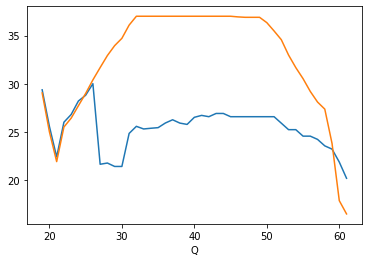

In [95]:
df_results.loc[df_results['episode'].isin(kids1)].groupby('Q')['action'].mean().plot()
df_results.loc[df_results['episode'].isin(kids0)].groupby('Q')['action'].mean().plot()

In [96]:
df_infos = pd.DataFrame(infos)

In [97]:
df_big = pd.concat([df_results, df_infos.drop('Q', axis=1)], axis=1)

In [98]:
df_big['L_plus'] = df_big['L'].shift(-1)
df_big['E_plus'] = df_big['E'].shift(-1)
df_big['action_plus'] = df_big['action'].shift(-1)

In [99]:
def no_more_educ(E, E_plus, Q):
    if E != E_plus and Q < 45:
        return 1
    else:
        return 0

df_big['educ_change'] = df_big.apply(lambda row: no_more_educ(row['E'], row['E_plus'], row['Q']), axis=1)

In [100]:
np.mean(df_big.loc[df_big['educ_change'] == 1][['Q', 'action', 'action_plus']])

Q              25.390225
action         17.943580
action_plus    19.007701
dtype: float64

In [101]:
np.mean(df_big.loc[(df_big['educ_change'] == 0) & (df_big['Q'] < 34)][['Q', 'action', 'action_plus']])

Q              26.027013
action         28.673831
action_plus    28.812242
dtype: float64

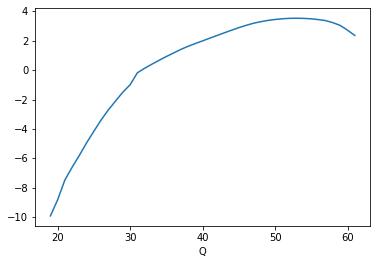

In [102]:
df_big.groupby('Q').mean()['scaled_reward'].plot()

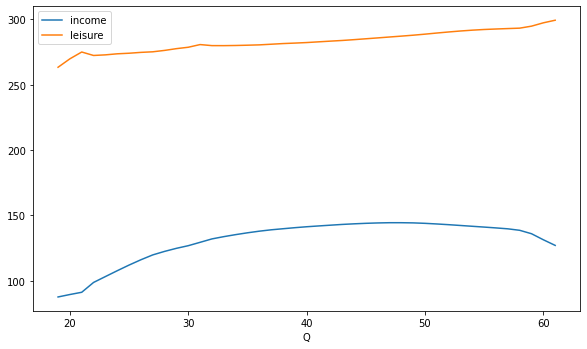

In [103]:
f, ax = plt.subplots(1,1, figsize=FIGSIZE)
np.sqrt(df_big.groupby('Q').mean()['Y']).plot(label='income')
(beta_L*np.sqrt(df_big.groupby('Q').mean()['L'])).plot(label='leisure')
ax.legend()

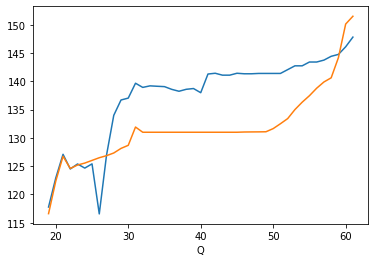

In [104]:
df_big.loc[df_results['episode'].isin(kids1)].groupby('Q')['L'].mean().plot()
df_big.loc[df_results['episode'].isin(kids0)].groupby('Q')['L'].mean().plot()

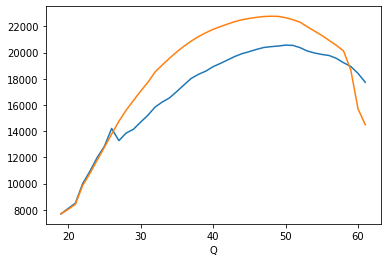

In [105]:
df_big.loc[df_results['episode'].isin(kids1)].groupby('Q')['Y'].mean().plot()
df_big.loc[df_results['episode'].isin(kids0)].groupby('Q')['Y'].mean().plot()

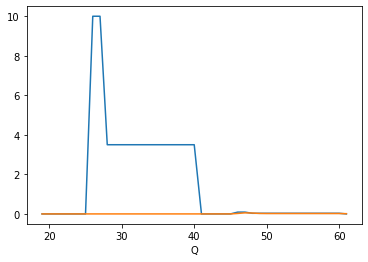

In [106]:
df_big.loc[df_results['episode'].isin(kids1)].groupby('Q')['J'].mean().plot()
df_big.loc[df_results['episode'].isin(kids0)].groupby('Q')['J'].mean().plot()

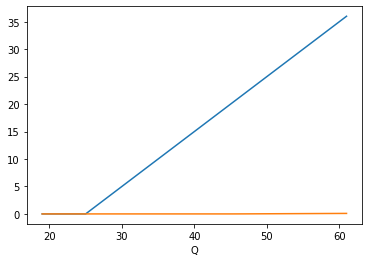

In [107]:
df_big.loc[df_big['episode'].isin(kids1)].groupby('Q')['c1'].mean().plot()
df_big.loc[df_big['episode'].isin(kids0)].groupby('Q')['c1'].mean().plot()

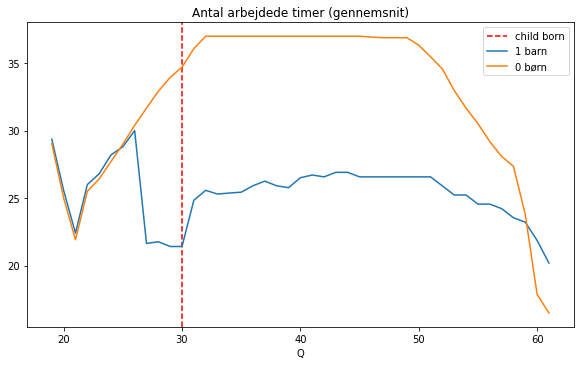

In [108]:
f, ax = plt.subplots(1,1, figsize=FIGSIZE)
ax.set_title("Antal arbejdede timer (gennemsnit)")
ax.axvline(x=30, label='child born', ls='--', color='red')

df_big.loc[df_results['episode'].isin(kids1)].groupby('Q')['action'].mean().plot(label='1 barn')
df_big.loc[df_results['episode'].isin(kids0)].groupby('Q')['action'].mean().plot(label='0 børn')

ax.legend()

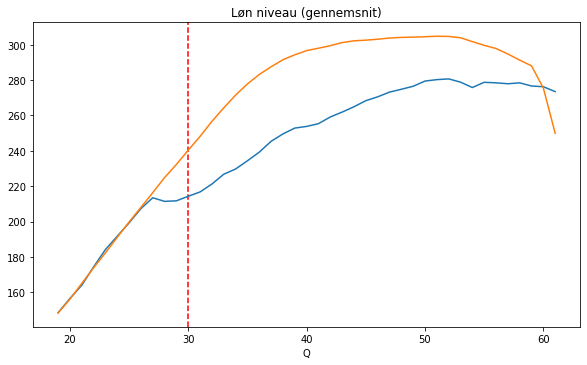

In [109]:
f, ax = plt.subplots(1,1, figsize=FIGSIZE)
ax.set_title("Løn niveau (gennemsnit)")
ax.axvline(x=30, label='child born', ls='--', color='red')

df_big.loc[df_results['episode'].isin(kids1)].groupby('Q')['S'].mean().plot(label='1 barn')
df_big.loc[df_results['episode'].isin(kids0)].groupby('Q')['S'].mean().plot(label='0 børn')

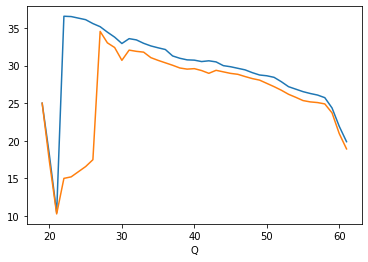

In [110]:
educ_end_20 = set(df_big.loc[(df_big['educ_change']==1) & (df_big['Q'] == 20)]['episode'])

educ_end_25 = set(df_big.loc[(df_big['educ_change']==1) & (df_big['Q'] == 25)]['episode'])

df_big.loc[df_results['episode'].isin(educ_end_20)].groupby('Q')['action'].mean().plot()

df_big.loc[df_results['episode'].isin(educ_end_25)].groupby('Q')['action'].mean().plot()


In [111]:
df_big['beta_L']

0         24.489796
1         24.489796
2         24.489796
3         24.489796
4         24.489796
            ...    
429995    24.489796
429996    24.489796
429997    24.489796
429998    24.489796
429999    24.489796
Name: beta_L, Length: 430000, dtype: float64

In [ ]:
N_EPISODES = 200000

results_ext = list()
infos_ext = list()
total_score_ext = list()

tic = time.time()
for episode in range(N_EPISODES):

    if episode % 50 == 0:
        print('Episode:', episode, 'epsilon:', agent.epsilon, f'total score (last 10): {np.mean(total_score[-10:-1]):.1f}')
        
        toc = time.time()
        time_for_50 = toc - tic
        remaining_episodes = N_EPISODES - episode
        
        print(f'time for 50 episodes:{time_for_50:.1f} seconds. Remaining {( remaining_episodes / 50 ) * time_for_50 / 60:.1f} minutes')
        tic = time.time()
        
    state = env.reset()
    
    done, G = False, 0
    while done is False:
        
        action = agent.choose_action(state)
        _action = transform_action(action)
        new_state, reward, done, info = env.step(_action)
        scaled_reward = reward_scaler_model2(reward, beta_L)
        
        state = new_state
        
        G += scaled_reward
        results_ext.append(create_return_array(state, _action, scaled_reward, episode))
        infos_ext.append(info)
        
    total_score_ext.append(G)
    

Episode: 0 epsilon: 0.0 total score (last 10): 4.0
time for 50 episodes:0.0 seconds. Remaining 0.2 minutes
Episode: 50 epsilon: 0.0 total score (last 10): 4.0
time for 50 episodes:1.5 seconds. Remaining 102.8 minutes
Episode: 100 epsilon: 0.0 total score (last 10): 4.0
time for 50 episodes:1.7 seconds. Remaining 111.8 minutes
Episode: 150 epsilon: 0.0 total score (last 10): 4.0
time for 50 episodes:1.5 seconds. Remaining 98.7 minutes
Episode: 200 epsilon: 0.0 total score (last 10): 4.0
time for 50 episodes:1.7 seconds. Remaining 112.5 minutes
Episode: 250 epsilon: 0.0 total score (last 10): 4.0
time for 50 episodes:1.5 seconds. Remaining 101.0 minutes
Episode: 300 epsilon: 0.0 total score (last 10): 4.0
time for 50 episodes:1.7 seconds. Remaining 110.8 minutes
Episode: 350 epsilon: 0.0 total score (last 10): 4.0
time for 50 episodes:1.5 seconds. Remaining 99.1 minutes
Episode: 400 epsilon: 0.0 total score (last 10): 4.0
time for 50 episodes:1.7 seconds. Remaining 109.9 minutes
Episode:

In [ ]:
def no_more_educ(E, E_plus, Q):
    if E != E_plus and Q < 45:
        return 1
    else:
        return 0

#df_big['educ_change'] = df_big.apply(lambda row: no_more_educ(row['E'], row['E_plus'], row['Q']), axis=1)

In [ ]:
states_cols = ['Q', 'G', 'K', 'Z', 'beta_L', 'E_prob', 'E', \
               'b1', 'b2', 'b3', 'b4', 'c1', 'c2', 'c3', 'c4',\
               'action', 'scaled_reward', 'episode']

In [ ]:
df_results_ext = pd.DataFrame(results_ext, columns=states_cols)
df_infos_ext = pd.DataFrame(infos_ext)
df_big_ext = pd.concat([df_results_ext, df_infos_ext.drop('Q', axis=1)], axis=1)

In [ ]:
df_big_ext['L_plus'] = df_big_ext['L'].shift(-1)
df_big_ext['E_plus'] = df_big_ext['E'].shift(-1)

df_big_ext['action_plus'] = df_big_ext['action'].shift(-1)

In [ ]:
df_big_ext['educ_change'] = df_big_ext.apply(lambda row: no_more_educ(row['E'], row['E_plus'], row['Q']), axis=1)

In [ ]:
df_big_ext['K_plus'] = df_big_ext['K'].shift(-1)
df_big_ext['K_minus'] = df_big_ext['K'].shift(1)
df_big_ext['K_plus_20'] = df_big_ext['K'].shift(-20)

In [ ]:

kids1 = set(df_big_ext.loc[(df_big_ext['K_minus'] == 0) & \
            (df_big_ext['K'] == 1) & (df_big_ext['Q'] == 30) & (df_big_ext['K_plus_20'] == 1)]['episode'])
kids0 = set(df_big_ext.loc[(df_big_ext['K_plus'] == 0) & (df_big_ext['K_plus_20'] == 0)]['episode'])

In [ ]:
f, ax = plt.subplots(1,1, figsize=FIGSIZE)
ax.set_title("Antal arbejdede timer (gennemsnit)")
ax.axvline(x=30, label='child born', ls='--', color='red')

df_big_ext.loc[df_big_ext['episode'].isin(kids1)].groupby('Q')['action'].mean().plot(label='1 barn')
df_big_ext.loc[df_big_ext['episode'].isin(kids0)].groupby('Q')['action'].mean().plot(label='0 børn')

ax.legend()

In [ ]:
f, ax = plt.subplots(1,1, figsize=FIGSIZE)
ax.set_title("Løn niveau (gennemsnit)")
ax.axvline(x=30, label='child born', ls='--', color='red')

df_big_ext.loc[df_big_ext['episode'].isin(kids1)].groupby('Q')['S'].mean().plot(label='1 barn')
df_big_ext.loc[df_big_ext['episode'].isin(kids0)].groupby('Q')['S'].mean().plot(label='0 børn')

In [ ]:
with open("..//data//women_hours_empirical", "rb") as f:
    women_hours_data = pickle.load(f)

f, ax = plt.subplots(1,1, figsize=FIGSIZE)
_x = range(18,60)
_xx = range(18, 61)
_mean = df_big_ext.loc[df_big_ext['action'] > 0].groupby('Q')['action'].mean()
_std = df_big_ext.loc[df_big_ext['action'] > 0].groupby('Q')['action'].std()
ax.plot(_xx, _mean, label='simulated')
ax.fill_between(_xx, _mean -_std, _mean + _std, alpha=0.3)
ax.plot(_x,women_hours_data[18:60], label = 'true')
ax.set_title("Average Working Hours (of women in labour force H>0)")
ax.legend()

In [ ]:
f, ax = plt.subplots(1,1,figsize=FIGSIZE)
plt.plot(df_big_ext.groupby('Q')['action'].mean(), label = 'Average Working Hours (of all women)')
ax.legend()

In [ ]:
df_big_ext.loc[df_big_ext['episode'].isin(kids1)].groupby('Q')['action'].mean().plot(label='1 barn')
df_big_ext.loc[df_big_ext['episode'].isin(kids0)].groupby('Q')['action'].mean().plot(label='0 børn')

In [ ]:
(df_big_ext.loc[df_big_ext['action'] > 0].groupby('Q')['Q'].count() / 50000).plot()

In [ ]:
#df_big_ext.to_pickle('..//data//extended_model_simulations.pkl')

In [ ]:
1 - df_big_ext.loc[df_big_ext['action'] > 0]['Q'].count() / df_big_ext.count()['Q']